<a href="https://colab.research.google.com/github/MohamadNasser7/MohamadNasser7/blob/main/BigDataBouns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#                   ***It always seems impossible until it’s done.***

**install pyspark and spark-nl libraries**

In [ ]:
! pip install -q pyspark==3.1.2 spark-nlp


**configurations for colab to run code correctly**

In [ ]:
import os

# Install java
! apt-get update -qq
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null

!wget -q https://archive.apache.org/dist/spark/spark-2.3.0/spark-2.3.0-bin-hadoop2.7.tgz

!tar xf spark-2.3.0-bin-hadoop2.7.tgz
!pip install -q findspark

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
os.environ["SPARK_HOME"] = "/content/spark-2.3.0-bin-hadoop2.7"
! java -version

import findspark
findspark.init()
from pyspark.sql import SparkSession

! pip install --ignore-installed -q spark-nlp==2.7.5

import sparknlp



openjdk version "1.8.0_312"
OpenJDK Runtime Environment (build 1.8.0_312-8u312-b07-0ubuntu1~18.04-b07)
OpenJDK 64-Bit Server VM (build 25.312-b07, mixed mode)


**import things ♾**

In [ ]:
import sparknlp
import pyspark
import pandas as pd
from google.colab import drive
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.embeddings import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import *
import pandas as pd
from pyspark.sql.functions import col
from pyspark.sql.functions import explode
from pyspark.sql.functions import countDistinct, avg, stddev
import matplotlib.pyplot as plt



**start function do all default configuration for object to start work without write it manually**

In [ ]:
spark = sparknlp.start()

**make the head of driver object points to given location**

In [ ]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**read parquet files containing data from my drive**

In [ ]:
df = spark.read.parquet("/content/drive/MyDrive/spark_nlp_dataset.parquet")


**create documentAssembler Trasformer to use it for to get data ready for other annotators**



In [ ]:
documentAssembler = DocumentAssembler().setInputCol("text").setOutputCol("document")

***create sentenceDetector to detected sentence boundres for each row of data ***

In [ ]:
sentenceDetector = SentenceDetector() \
.setInputCols(["document"])\
.setOutputCol("sentence")


**`create tokenizer to split lines to tokens each token represent a word `**

In [ ]:
tokenizer = Tokenizer() \
    .setInputCols(["sentence"]) \
    .setOutputCol("token")

**load pre trained WordEmbeddingsModel("Glove") to use it in pipeline and set the language to english**

In [ ]:
word_emb_glove = WordEmbeddingsModel.pretrained("glove_100d", lang="en")


glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


**load pre trained PerceptronModel to use it in pipeline for the data **

In [ ]:
per_pos_model = PerceptronModel.pretrained("pos_anc", lang="en")


pos_anc download started this may take some time.
Approximate size to download 4.3 MB
[OK!]


***load pre trained NerCrfModel to use it in pipeline for the data ***

In [ ]:
ner_with_glove = NerCrfModel.pretrained("ner_crf", lang="en")

ner_crf download started this may take some time.
Approximate size to download 10.1 MB
[OK!]


**create a PipeLine with the the 6 stages we defined up**

In [ ]:
recursivePipeline = RecursivePipeline(stages=[
        documentAssembler,
        sentenceDetector, 
        tokenizer,
        word_emb_glove,
        per_pos_model,
        ner_with_glove
])

**create a model from defined pipeline to use it to transform data and get the results**

In [ ]:
fitted_model = recursivePipeline.fit(df)


***apply generated model on the original data to get the results ***

In [ ]:
new_df = fitted_model.transform(df)


**the result for each stage in the pipeline**

In [ ]:
df.show(1,False)
new_df.select("document.result").show(1,False)
new_df.select("sentence.result").show(1,False)
new_df.select("token.result").show(1,False)
new_df.select("embeddings.result").show(1,False)
new_df.select("pos.result").show(1,False)
new_df.select("ner.result").show(1,False)

+-------------------------------------------+
|text                                       |
+-------------------------------------------+
|Reuters historical calendar - September 7 .|
+-------------------------------------------+
only showing top 1 row

+---------------------------------------------+
|result                                       |
+---------------------------------------------+
|[Reuters historical calendar - September 7 .]|
+---------------------------------------------+
only showing top 1 row

+---------------------------------------------+
|result                                       |
+---------------------------------------------+
|[Reuters historical calendar - September 7 .]|
+---------------------------------------------+
only showing top 1 row

+---------------------------------------------------+
|result                                             |
+---------------------------------------------------+
|[Reuters, historical, calendar, -, September, 7, .]|
+-

**show (Named *Entity* Recognition ) stage results**

```
# This is formatted as code
```



In [ ]:
ner = new_df.select(explode("ner")).select(col("col.result").alias("ner"))
ner.show()

+-----+
|  ner|
+-----+
|I-ORG|
|    O|
|    O|
|    O|
|    O|
|    O|
|    O|
|    O|
|    O|
|    O|
|    O|
|    O|
|    O|
|    O|
|    O|
|    O|
|    O|
|    O|
|    O|
|    O|
+-----+
only showing top 20 rows



**Convert from SparkDataFrame to Pandas Dataframe to do some ploting 😠**

In [ ]:
pner = ner.toPandas()

**Plot bar char to see each categorie of *NER* how many times be predected **

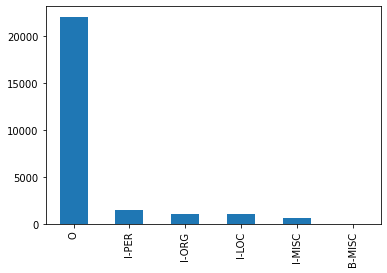

In [ ]:
pner["ner"].value_counts().plot(kind='bar')
plt.show()



 **We can see that the Most frequent *NER* Categorie appears is *"O"* wich is not refers to entities of interest**


**show (PART OF SPEECH ) stage results**


In [ ]:

pos = df_with_annotations.select(explode("pos")).select(col("col.result").alias("pos"))
pos.show()

+---+
|pos|
+---+
|NNP|
| JJ|
| NN|
|  -|
|NNP|
| CD|
|  .|
|VBG|
|VBP|
| DT|
| IN|
| DT|
| JJ|
|NNS|
| TO|
| VB|
|VBN|
| IN|
|NNP|
| CD|
+---+
only showing top 20 rows



Convert from SparkDataFrame to Pandas Dataframe to do some ploting 😠

In [ ]:
ppos = pos.toPandas()

**Plot bar char to see each categorie of *POS* how many times be predected **

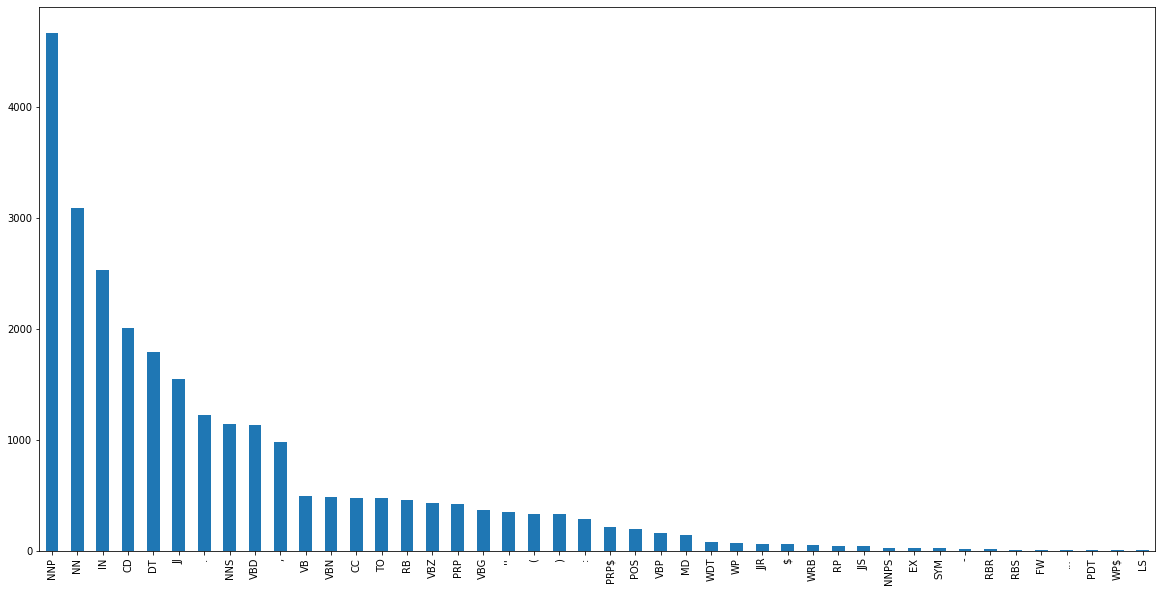

In [ ]:
ppos["pos"].value_counts().plot(kind='bar',figsize=(20, 10))
plt.show()



 **We can see that the Most frequent *POS* Categorie appears is *"NNP"* wich is  refers to proper noun **


**Merge the two dataframes above to one dataframe containg each POS AND NER predection for each token**

In [ ]:
pos_items = pd_df_annotated.pos.apply(pd.DataFrame).tolist()
ner_items = pd_df_annotated.ner.apply(pd.DataFrame).tolist()


pos_df = pd.concat(pos_items)[[3]]
ner_df = pd.concat(ner_items)[[3]]

result = pd.concat([pos_df, ner_df], axis=1, sort=False)
result.columns = ["POS", "NER"]

result

,POS,NER
0,NNP,I-ORG
1,JJ,O
2,NN,O
3,-,O
4,NNP,O
...,...,...
7,CD,O
8,),O
0,NNP,O
1,:,O


Groub the data to see each distinic pair of (POS,NER) how many times appear in the data

In [ ]:
stats = result.groupby(["POS","NER"]).size().rename("count").reset_index().sort_values('count').loc[:,["POS","NER","count"]]
stats

,POS,NER,count
39,NNP,B-MISC,1
56,RB,I-LOC,1
48,NNPS,O,1
33,LS,O,1
22,IN,I-MISC,1
...,...,...,...
43,NNP,I-PER,1446
18,DT,O,1782
15,CD,O,1998
25,IN,O,2503


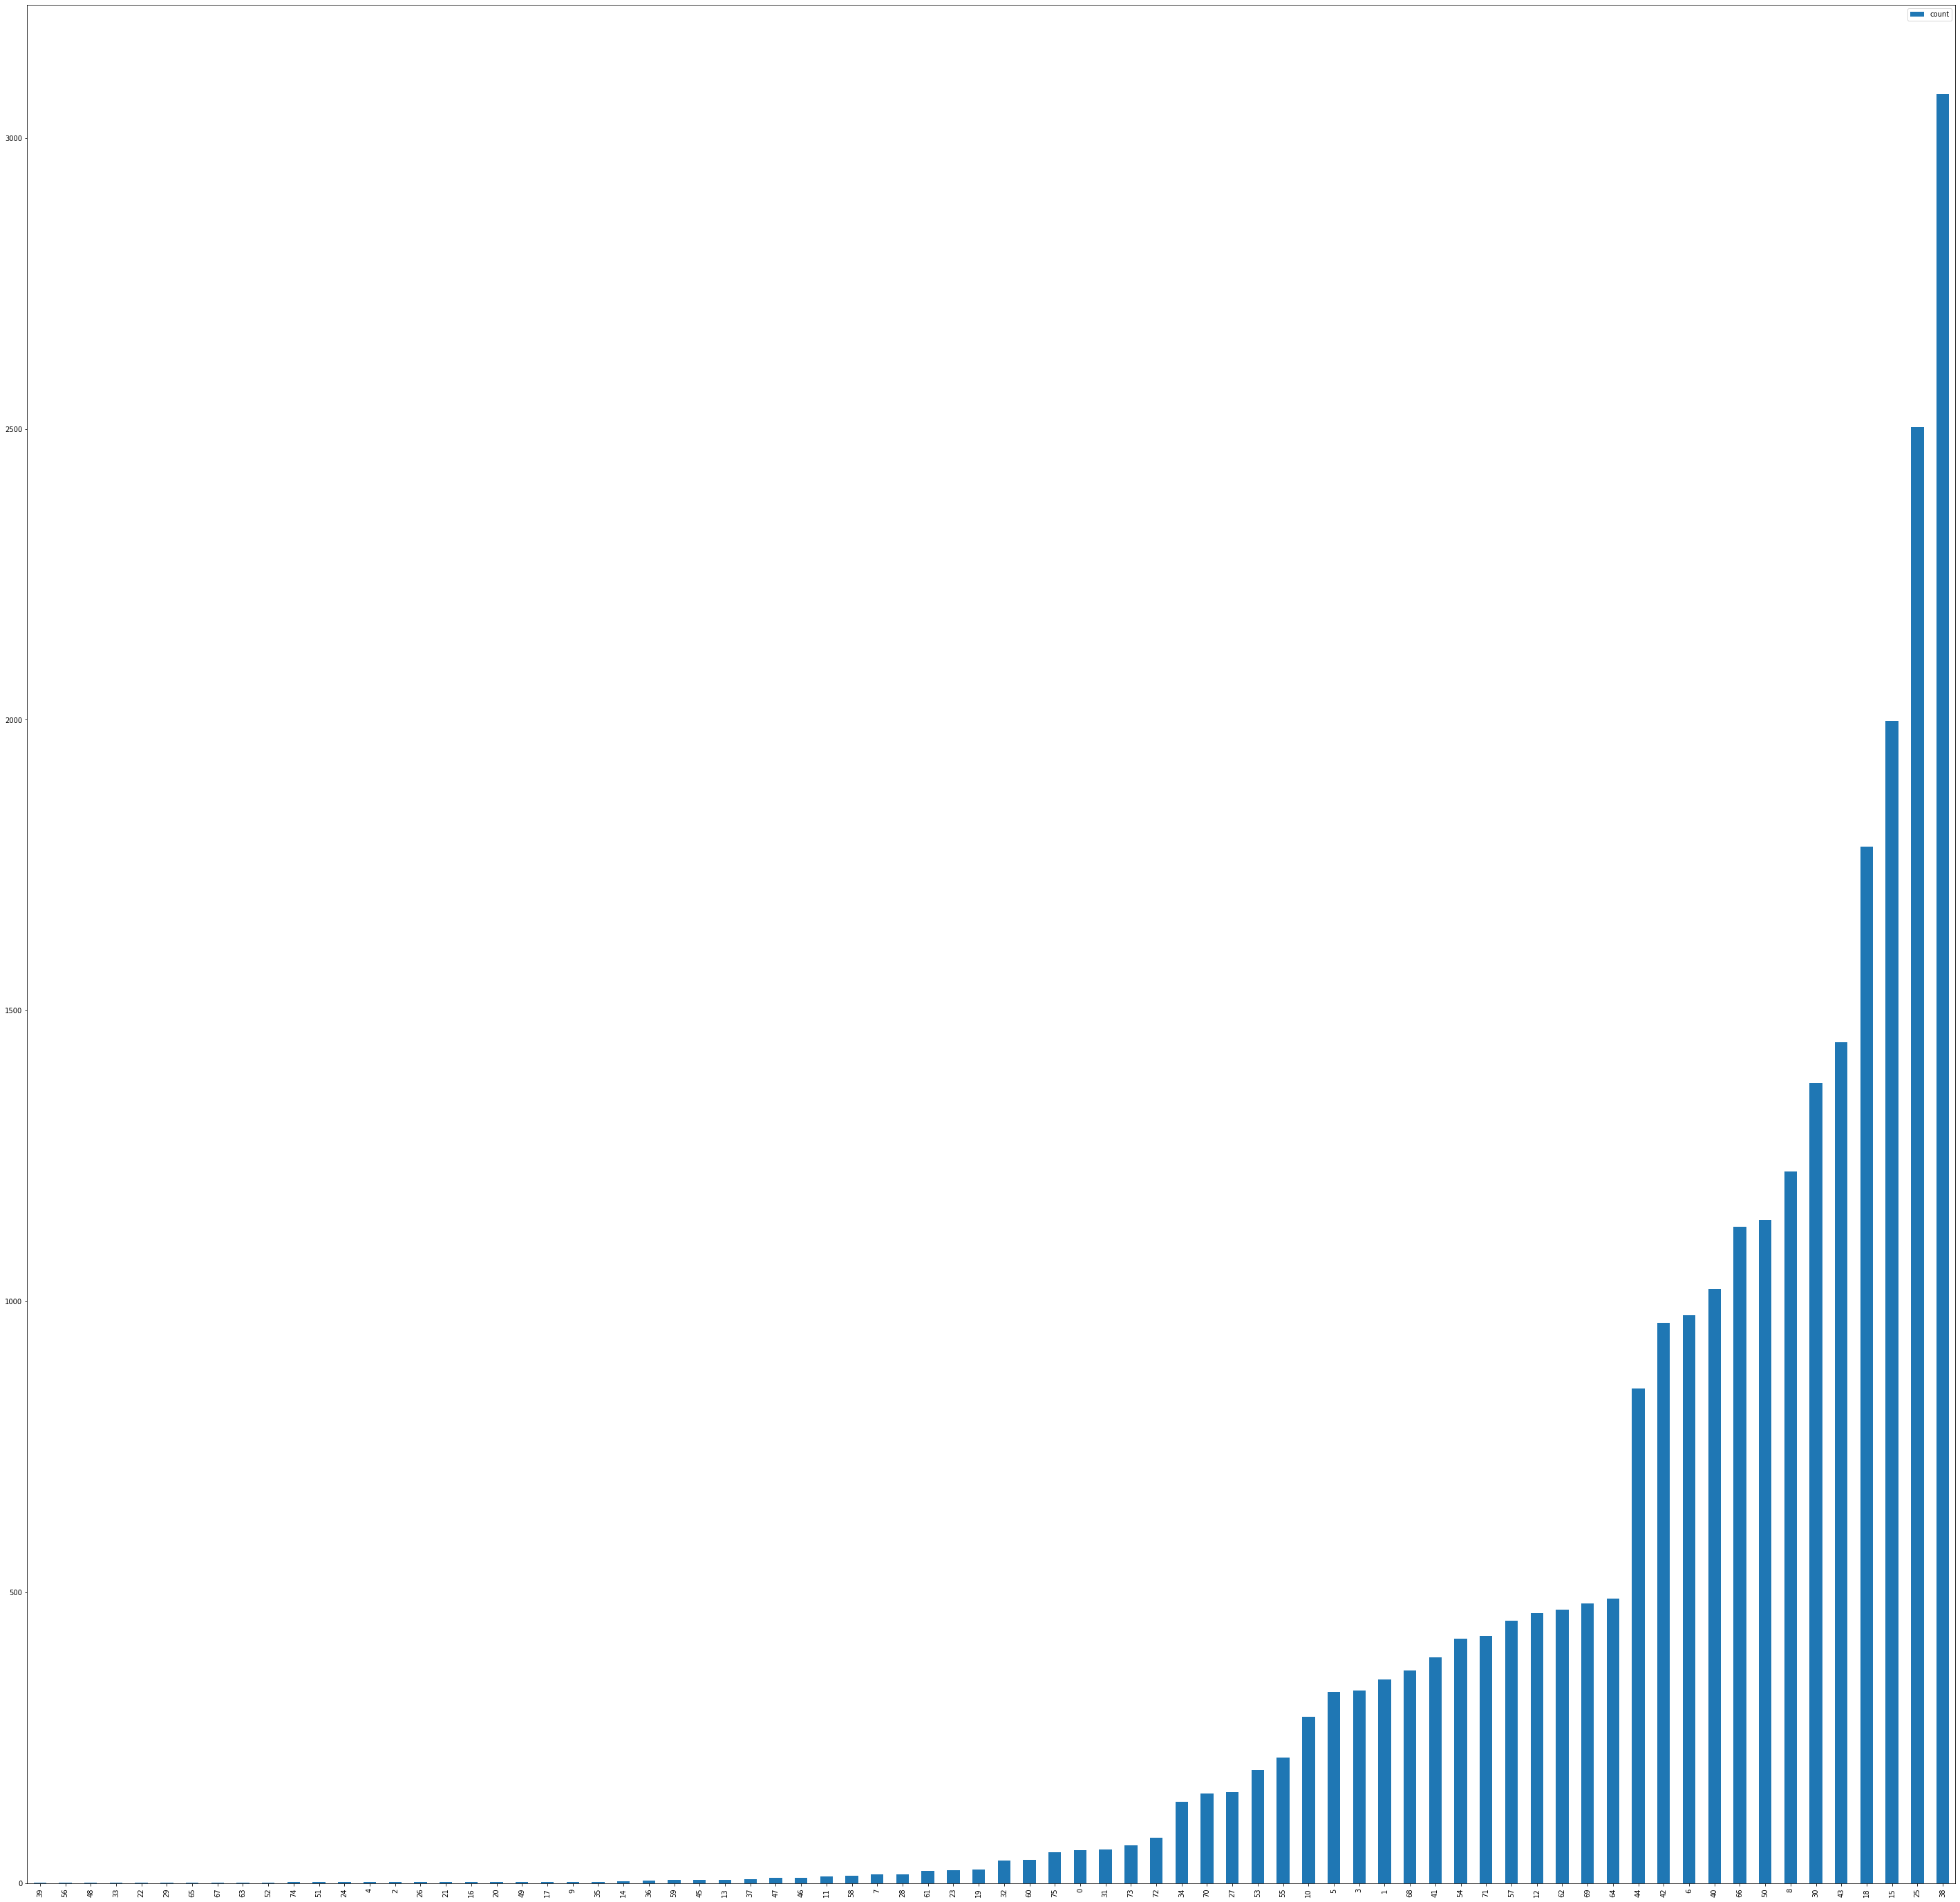

In [ ]:
stats.plot.bar(figsize=(50, 50))


**for each "POS" categorie  see how many times model recognise that these word is named entity -> its not "O" categorie**

In [ ]:
pvalues = result["POS"].unique().tolist()
counts = []
for i in pvalues:
  counts.append(len(result[result["POS"]==i]["NER"]!="O"))


**make DataFrame contains the "POS" categories and Count of Recognized and plot the result **


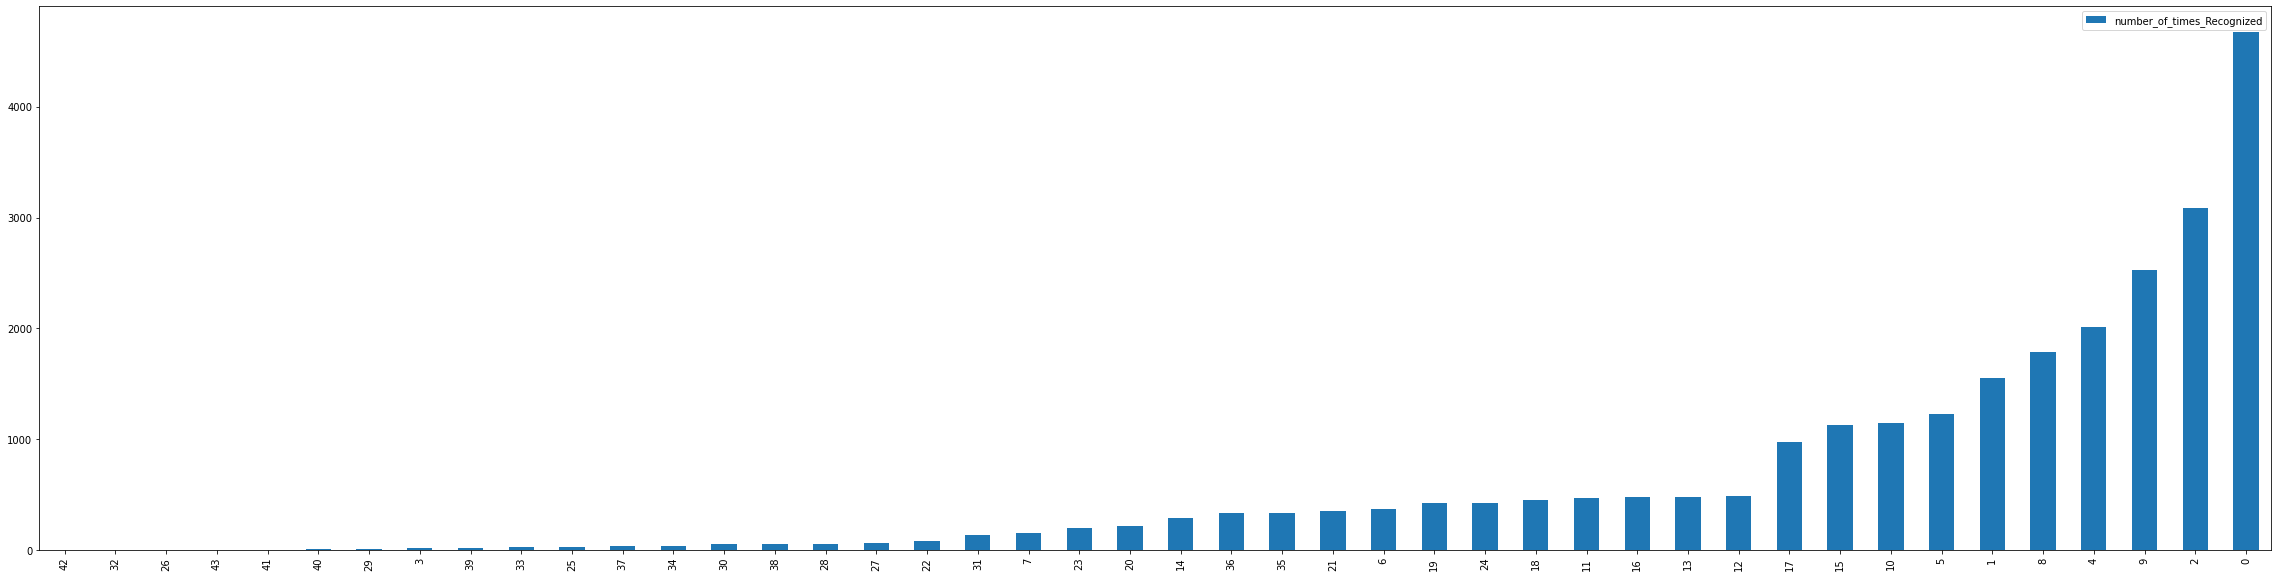

In [ ]:
d = {"POS":pvalues,"number_of_times_Recognized":counts}
pd.DataFrame(d).sort_values("number_of_times_Recognized").plot.bar(figsize=(40, 10))



We can see that the most frequant "POS" categorie that been recognized by model is "NNP" **bold text**

**Wich is considered a good sign becouse its makes sense that the nouns or persons Names is the largest Categorie appears in any text in average cases**